# Recurrent Neural Networks for Sentiment Analysis

An RNN is a type of artificial neural network used for sequence modelling. RNNs include recursive components in their structure; and hence, the name comes Recurrent Neural Networks. These sort of NNs work very well in modelling sequences. As text is also a from of sequence, we will use RNNs to classify IMDB reviews into positive/negative classes. 

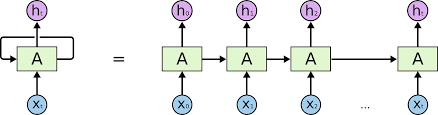

## Overview:
1. Preparing the data
    * Creating tf dataset
    * Finding unique tokens
    * Encoding unique words
    * Divide the dataset into mini-batches
2. Embedding layers
3. LSTM
4. Building an RNN model
5. Training and evaluation
6. Define a Custom function for building RNNs with different architectures

## Data Preparation

The dataset we are going to work with is stored in a csv file. Lets go ahead and read it as a pandas dataframe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
df = pd.read_csv("movie_data.csv", encoding="utf-8")

In [3]:
df.head()

,review,sentiment
0,"Often tagged as a comedy, The Man In The White...",1
1,After Chaplin made one of his best films: Doug...,0
2,I think the movie was one sided I watched it r...,0
3,I have fond memories of watching this visually...,1
4,This episode had potential. The basic premise ...,0


In [4]:
df.shape

(50000, 2)

### 1. Create tf dataset

Our dataset contains 50k reviews labelled as positive or negative. Next, lets convert this dataframe into tensorflow dataset for efficiency purposes.

In [5]:
target = df.pop('sentiment')

ds = tf.data.Dataset.from_tensor_slices(
    (df.values, target.values))


In [6]:
# ds = tf.data.Dataset.from_tensor_slices((df["review"].values, df["sentiment"].values))

In [7]:
for ex in ds.take(1):
    print(f"Review: {ex[0].numpy()}")
    print(f"Sentiment: {ex[1].numpy()}")

Review: [b"Often tagged as a comedy, The Man In The White Suit is laying out far more than a chuckle here and there.<br /><br />Sidney Stratton is an eccentric inventor who isn't getting the chances to flourish his inventions on the world because nobody pays him notice, he merely is the odd ball odd job man about the place as it were. After bluffing his way into Birnley's textile mill, he uses their laboratory to achieve his goal of inventing a fabric that not only never wears out, but also never needs to be cleaned!. He is at first proclaimed a genius and those who ignored him at first suddenly want a big piece of him, but then the doom portents of an industry going bust rears its head and acclaim quickly turns to something far more scary.<br /><br />Yes the film is very funny, in fact some scenes are dam hilarious, but it's the satirical edge to the film that lifts it way above the ordinary to me. The contradictions about the advent of technology is a crucial theme here, do we want i

Next, lets split the dataset into training, validation, and testing datasets. We will save 25000 reviews for testing and split the rest into 20000 training and 5000 validation examples.

In [8]:
ds = ds.shuffle(50000, reshuffle_each_iteration=False)

ds_test = ds.take(25000)
ds = ds.skip(25000)

ds_train = ds.take(20000)
ds = ds.skip(20000)

ds_valid = ds.take(5000)

### 2. Find unique tokens

Strings or characters as an input is not the best way to feed to a machine learning model. Therefore, we need to find a way to convert the reviews into integers or some sort of representation that our machine can work with more efficiently. One such technique is tokenization. Here, first we gonna find unique tokens and then we will encode them into mathematical representation. Lets go ahead and do it. 

In [9]:
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.Tokenizer()

from collections import Counter
counter = Counter()

for ex in ds_train:
    tokens = tokenizer.tokenize(ex[0].numpy()[0])
    counter.update(tokens)

In [10]:
len(counter)

87363

### 3. Encode unique words

In [11]:
encoder = tfds.deprecated.text.TokenTextEncoder(counter)

In [12]:
example = "This is an example."
print(encoder.encode(example))

[208, 9, 10, 1441]


Next, lets transform the each text in the datatset accordingly.

In [13]:
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    
    return encoded_text, label


def encode_map_fn(text, label):
    return tf.py_function(encode, inp = [text, label], Tout = (tf.int64, tf.int64))

In [14]:
# mapping
ds_train = ds_train.map(encode_map_fn)
ds_valid = ds_valid.map(encode_map_fn)
ds_test = ds_test.map(encode_map_fn)

### 4. Split the data into mini-batches

So far we have converted the sequence of words into integers. However, there is one big problem that is all the sequences are of different length. One solution is to use padded_batch which pads the sequences in a batch to match the length of the longest sequence found. 

In [15]:
train_data = ds_train.padded_batch(32, padded_shapes=([-1],[]))
valid_data = ds_valid.padded_batch(32, padded_shapes=([-1],[]))
test_data = ds_test.padded_batch(32, padded_shapes=([-1],[]))

## Embedding Layers

As we can see that we have more than 87,000 unique words, which will also be the number of our input features, a model trained on such features may suffer from curse of dimensionality. Here, the embedding layers come into play. Not only embedding helps reducing dimensionality but also capable of learning salient features (beacuse embedding layer can be optimized).

In [16]:
from tensorflow.keras.layers import Embedding
model = tf.keras.Sequential()
model.add(Embedding(input_dim=100, output_dim=6, input_length=20))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 6)             600       
                                                                 
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


## Building an RNN Model

In [17]:
vocab_size = len(counter) + 2
embedding_dim = 20
tf.random.set_seed(1)

# build model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Normalization, Activation
lstm_model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="Embedding-layer"),
    
    Bidirectional(LSTM(2), name="Bidir-LSTM"),
    
    Dense(4, name="Dense-1"),
    Normalization(),
    Activation("relu"),
    Dropout(0.5),
    
    Dense(1, name="Dense-2"),
])   
    
    
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding-layer (Embedding)  (None, None, 20)         1747300   
                                                                 
 Bidir-LSTM (Bidirectional)  (None, 4)                 368       
                                                                 
 Dense-1 (Dense)             (None, 4)                 20        
                                                                 
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 activation (Activation)     (None, 4)                 0         
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                      

## Training and Evaluation

In [18]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [19]:
lstm_model.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
625/625 [==============================] - 118s 181ms/step - loss: 0.6341 - accuracy: 0.6108 - val_loss: 0.5659 - val_accuracy: 0.7748
Epoch 2/10
625/625 [==============================] - 39s 63ms/step - loss: 0.5402 - accuracy: 0.7297 - val_loss: 0.4830 - val_accuracy: 0.7876
Epoch 3/10
625/625 [==============================] - 40s 64ms/step - loss: 0.4438 - accuracy: 0.7905 - val_loss: 0.4480 - val_accuracy: 0.8050
Epoch 4/10
625/625 [==============================] - 39s 63ms/step - loss: 0.3909 - accuracy: 0.8210 - val_loss: 0.4494 - val_accuracy: 0.8196
Epoch 5/10
625/625 [==============================] - 39s 63ms/step - loss: 0.3600 - accuracy: 0.8367 - val_loss: 0.4477 - val_accuracy: 0.8150
Epoch 6/10
625/625 [==============================] - 39s 63ms/step - loss: 0.3420 - accuracy: 0.8393 - val_loss: 0.4715 - val_accuracy: 0.8168
Epoch 7/10
625/625 [==============================] - 40s 63ms/step - loss: 0.3148 - accuracy: 0.8514 - val_loss: 0.4579 - val_accurac

In [20]:
lstm_model.evaluate(test_data)

782/782 [==============================] - 30s 39ms/step - loss: 0.4716 - accuracy: 0.8300


[0.47158870100975037, 0.8299999833106995]